In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

# Download data

In [2]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

data_set = 'mnist'

if data_set == 'mnist':
    raw_data = fetch_openml('mnist_784')
else:
    assert False

In [3]:
raw_data_x = np.array((raw_data['data']+0.5)/256.0)
raw_data_y = np.array(raw_data['target'].astype('int8'))

# separate classes 0,1,2 into a new dataset
# accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)| (raw_data_y == 2)
accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)

raw_data_x = raw_data_x[accptbl_cats]
raw_data_y = raw_data_y[accptbl_cats]
num_classes = 2
img_sz = (28,28)

data_dim = raw_data_x.shape[1]

## Split data into training and validation

In [4]:
def display_image(x,lbl=None):
    plt.imshow(x.reshape(img_sz))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

def split_data(x,y,fracs=[0.8,0.2],seed=0):
    if seed is not None:
        np.random.seed(seed)
    N = x.shape[0]
    rp = np.random.permutation(N)

    N1 = int(fracs[0]*N)
    N2 = min(N-N1,int(fracs[1]*N))

    # Split the data into two parts
    x1 = x[rp[:N1]]
    y1 = y[rp[:N1]]
    x2 = x[rp[N1:(N1+N2)]]
    y2 = y[rp[N1:(N1+N2)]]

    return x1,y1,x2,y2

In [5]:
train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[0.01,0.01])
train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=[0.6,0.4])

In [6]:
print('num_train = ' + str(train_x.shape[0]))
print('num_val = ' + str(val_x.shape[0]))
print('num_test = ' + str(test_x.shape[0]))
print('num_classes = '+str(num_classes))

num_train = 88
num_val = 58
num_test = 147
num_classes = 2


# Explore the data

48.86% of the training data is class 0, corresponding to 43 data points
51.14% of the training data is class 1, corresponding to 45 data points


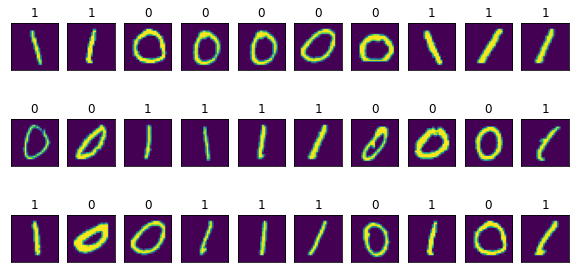

In [7]:
# Print statistics
num_train = len(train_y)
for i in range(num_classes):
    num_class_i = np.sum(train_y == i)
    print('{:.2f}% of the training data is class {}, corresponding to {} data points'.format(100*num_class_i/num_train,
                                                                                       i, num_class_i))

# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_image(train_x[ind,:],
                train_y[ind])



# Extract SIFT keypoints and descriptors

## Prepare data

In [8]:
# convert train images to 2D with [0,255] color values
train_x_sift = ((train_x.reshape((train_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
train_x_sift = np.broadcast_to(train_x_sift, (train_x.shape[0], img_sz[0], img_sz[1], 3))

In [9]:
def display_color_image(img, lbl=None):
    plt.imshow(img.reshape((img_sz[0], img_sz[1], 3)))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

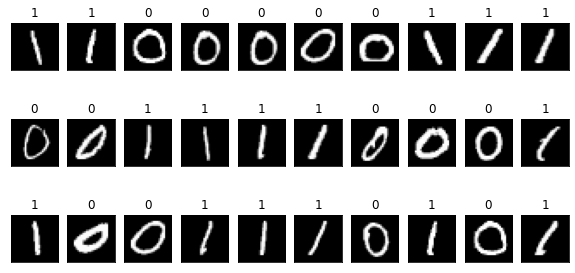

In [10]:
# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x_sift.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_color_image(train_x_sift[ind], train_y[ind])

## Extract SIFT keypoints and descriptors

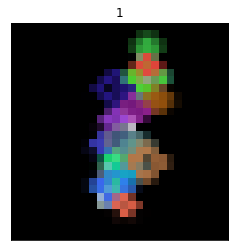

In [163]:
# extract SIFT descriptors for one image
gray= cv.cvtColor(train_x_sift[20],cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create(nOctaveLayers = 20, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)
kp, des = sift.detectAndCompute(gray,None)
img=cv.drawKeypoints(gray,kp,0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display_color_image(img, train_y[20])

In [164]:
# extract SIFT descriptors for all training data
gray = np.array([cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)])
for i in range(1, train_x_sift.shape[0]):
    gray = np.append(gray, [cv.cvtColor(train_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
kp = [] # list of tuples of keypoints for all images
des = [] # list of 2D arrays containing multiple descriptors for each image
for i in range(gray.shape[0]):
    _kp, _des = sift.detectAndCompute(gray[i],None)
    kp.append(_kp)
    des.append(_des)

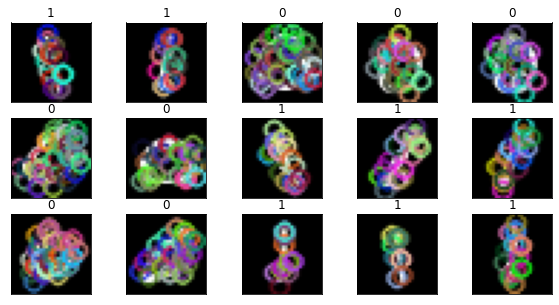

In [165]:
# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,gray.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray[ind],kp[ind],0)
    #img=cv.drawKeypoints(gray[ind],kp[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, train_y[ind])

In [166]:
# show statistics of the number of keypoints found in each training image
num_keypoints = [len(kp[i]) for i in range(len(kp))]
print('# of training images: '+ str(len(num_keypoints)))
print('min # of keypoints: ' + str(min(num_keypoints)))
print('max # of keypoints: ' + str(max(num_keypoints)))
for i in range(1):
    temp = np.sum([k==i for k in num_keypoints])/len(num_keypoints)*100
    print('{:.1f}% of training images have {} keypoints'.format(temp, i))

# of training images: 88
min # of keypoints: 10
max # of keypoints: 42
0.0% of training images have 0 keypoints


## Discard images with 0 keypoints

In [167]:
# discard all images that have less than 1 keypoint
to_discard_ind = [i for i in range(len(num_keypoints)) if num_keypoints[i]==0]
train_x_sift_mod = np.delete(train_x_sift, to_discard_ind, axis=0)
train_y_mod = np.delete(train_y, to_discard_ind, axis=0)
gray_mod = np.delete(gray, to_discard_ind, axis=0)
kp_mod = [kp[i] for i in range(len(kp)) if i not in to_discard_ind]
des_mod = [des[i] for i in range(len(des)) if i not in to_discard_ind]

# of training images: 88
min # of keypoints: 10
max # of keypoints: 42
0.0% of training images have 0 keypoints


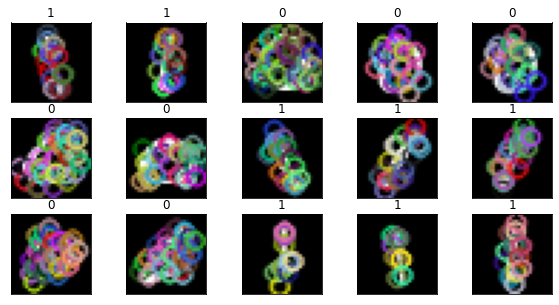

In [168]:
# show statistics of the number of keypoints found in each training image
num_keypoints_mod = [len(kp_mod[i]) for i in range(len(kp_mod))]
print('# of training images: '+ str(len(num_keypoints_mod)))
print('min # of keypoints: ' + str(min(num_keypoints_mod)))
print('max # of keypoints: ' + str(max(num_keypoints_mod)))
for i in range(1):
    temp = np.sum([k==i for k in num_keypoints_mod])/len(num_keypoints_mod)*100
    print('{:.1f}% of training images have {} keypoints'.format(temp, i))

# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,gray_mod.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, train_y_mod[ind])

In [169]:
# save feature vectors and labels of all images
# np.savetxt('../../data/des1.txt', np.array(des_mod))
# np.savetxt('../../data/lbls1.txt', train_y_mod)

In [170]:
# normalize feature vectors
des_mod = [d / (d @ np.ones(d.shape[1]))[:, np.newaxis] for d in des_mod]

# Create similarity graph

#### image $i$ has $k_i$ keypoints and descriptors $f^i_s , s=1,...,k_i$

#### $ I(f^i_s, f^j_t) = 1 $ if $ ||f^i_s - f^j_t||^2_2 \leq \tau $ , and $0$ otherwise 

#### $ w_{ij} = \frac{\sum_{st=1,1}^{k_i, k_j} I(f^i_s, f^j_t)}{N_{ij}} $ or $ w_{ij} = \frac{\sum_{s=1}^{k_i} logic \sum_{t=1}^{kj} I(f^i_s, f^j_t)}{N_{ij}} $

#### Where $N_{ij}$ is the normalization factor and $\tau$ is the matching threshold 

In [171]:
# First definition of w_ij and N_ij

# tau = 0.02
# num_imgs = len(des_mod)

# W = np.zeros((num_imgs, num_imgs))
# for i in range(num_imgs):
#     for j in range(num_imgs):
#         # find out number of keypoints of image i and j
#         ki = des_mod[i].shape[0]
#         kj = des_mod[j].shape[0]
        
#         # calculate normalization factor
#         Nij = ki*kj
        
#         # find out if any descriptor of image i matches any descriptor of image j
#         matches = [[np.sum((des_mod[i][s] - des_mod[j][t]) ** 2) <= tau for t in range(kj)] for s in range(ki)]
#         matches = np.array(matches)
        
#         # calculate w_ij
#         W[i][j] = np.sum(matches) / Nij

In [172]:
# Second definition of w_ij and N_ij

tau = 0.01
num_imgs = len(des_mod)

W = np.zeros((num_imgs, num_imgs))
for i in range(num_imgs):
    for j in range(num_imgs):
        # find out number of keypoints of image i and j
        ki = des_mod[i].shape[0]
        kj = des_mod[j].shape[0]
        
        # calculate normalization factor
        Nij = ki
        
        # find out if any descriptor of image i matches any descriptor of image j
        matches = [any([np.sum((des_mod[i][s] - des_mod[j][t]) ** 2) <= tau for t in range(kj)]) for s in range(ki)]
        matches = np.array(matches)
        
        # calculate w_ij
        W[i][j] = np.sum(matches) / Nij

# Display learned graph

In [173]:
def hist_of_entries(M, num_bins, lx=None, lbl=None):
    
    plt.figure()
    _ = plt.hist(M.reshape(-1),num_bins)
    
    if lx is not None:
        plt.xlim([-lx, lx])
    
    if lbl is not None:
        _ = plt.title(lbl)

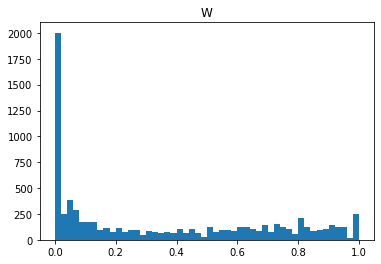

In [174]:
# show histogram of entries in W
hist_of_entries(W, 50, lx=None, lbl='W')

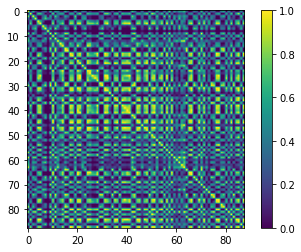

In [175]:
# show adjacency matrix
_ = plt.imshow(W)
_ = plt.colorbar()

In [176]:
def ordered(W, x):
    """
    Orders the adjacency matrix w.r.t. image labels. All 0's come first and then all 1's.
    
    Input: W, x
    W - NxN adjacency matrix of the similarity graph
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    
    Output: W_ord, order
    W_ord - NxN adjacency matrix where all 0-labeled nodes come first and then all 1-labeled nodes
    order - Nx1 vector showing order of images
    """
    
    order1 = np.arange(x.shape[0])
    
    W1 = W[x == -1, :]
    W1 = np.append(W1, W[x == 1, :], axis=0)
    
    W_ord = W1[:,x == -1]
    W_ord = np.append(W_ord, W1[:,x == 1], axis=1)
    
    order = order1[x == -1]
    order = np.append(order, order1[x == 1])
    
    return W_ord, order

There are 43 zero-labeled vertices and 43 one-labeled vertices.


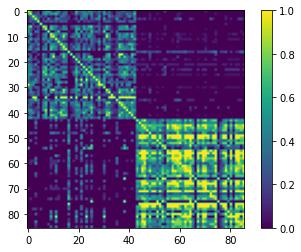

In [161]:
# show ordered adjacency matrix
x = train_y_mod*2-1
W_ord, order = ordered(W, x)
_ = plt.imshow(W_ord)
_ = plt.colorbar()

print('There are {} zero-labeled vertices and {} one-labeled vertices.'.format(np.sum(x == -1), np.sum(x == 1)))

There are 43 zero-labeled vertices and 45 one-labeled vertices.


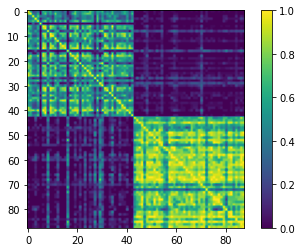

In [177]:
# show ordered adjacency matrix
x = train_y_mod*2-1
W_ord, order = ordered(W, x)
_ = plt.imshow(W_ord)
_ = plt.colorbar()

print('There are {} zero-labeled vertices and {} one-labeled vertices.'.format(np.sum(x == -1), np.sum(x == 1)))

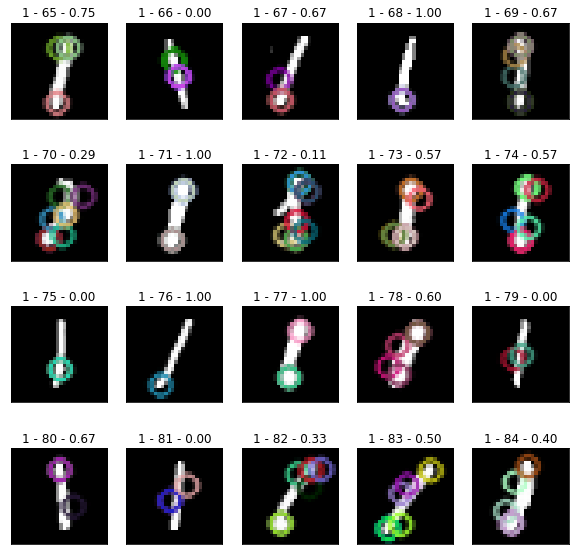

In [162]:
# visualize a few problematic images and their keypoints
num_digits = 5
num_rows = 4
plt.figure(figsize=(10,10))
for i in range(num_rows*num_digits):
    ind = order[65+i]
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, str(train_y_mod[ind])+' - '+str(65+i)+' - {:.2f}'.format(W_ord[65+i][50]))